In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf

# Import necessary layers for building the neural network
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
# Import the Sequential model API for creating a linear stack of layers
from tensorflow.keras.models import Sequential
# Import optimizers for updating the model's weights during training
from tensorflow.keras.optimizers import SGD, Adam
# Import callbacks for training behavior control
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [111]:
data_ = pd.read_csv('https://github.com/vmahawar/data-science-datasets-collection/raw/main/reliance_stock.csv', index_col='Date', parse_dates=['Date'])

# pd.read_csv(...): This line uses the read_csv function from the pandas library (imported as pd) to read data from a CSV (Comma-Separated Values) file.
# /content/drive/MyDrive/Colab Notebooks/TimesPro/RELIANCE.NS.csv: This is the file path specifying the location of the CSV file containing the data.
# index_col='Date': This argument sets the 'Date' column as the index (row labels) of the resulting DataFrame.
# parse_dates=['Date']: This tells pandas to interpret the 'Date' column as dates, making it easier to work with time-series data.
# data_: The data read from the CSV file is stored in a pandas DataFrame named data_. A DataFrame is a table-like data structure, like a spreadsheet.

row_with_nan = data_[data_.isnull().any(axis=1)].iloc[0]
print(row_with_nan)


print(f"Dataset shape before dropping NAN value rows: {data_.shape}")

data = data_.dropna(inplace=False)   #returns a new data frame

# data = data_.dropna(inplace=False): This is a crucial step where rows containing "Not a Number" (NaN) values are removed.
# dropna() is a pandas function that drops rows or columns with missing values.
# inplace=False means that the original data_ DataFrame is not modified. Instead, a new DataFrame named data is created without the NaN values.

print(f"Dataset shape after dropping NAN value rows: {data.shape}")

Open        NaN
High        NaN
Low         NaN
Close       NaN
Adj Close   NaN
Volume      NaN
Name: 1996-01-26 00:00:00, dtype: float64
Dataset shape before dropping NAN value rows: (6291, 6)
Dataset shape after dropping NAN value rows: (6164, 6)


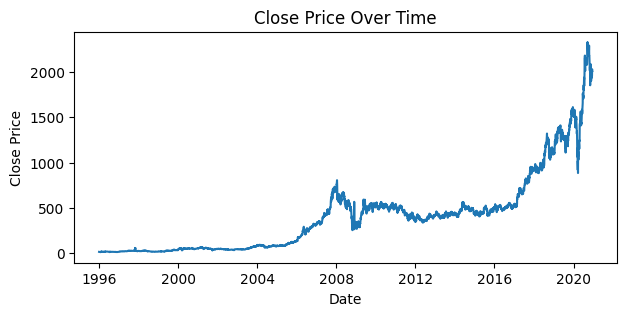

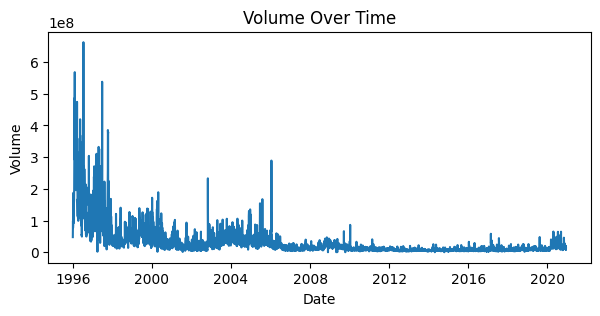

In [90]:
# Visualize the data using a line plot
plt.figure(figsize=(7, 3))
plt.plot(data['Close'])
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# You can also visualize other columns like Open, High, Low, Volume
# Example for Volume:
plt.figure(figsize=(7, 3))
plt.plot(data['Volume'])
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

In [112]:
data = data.filter(['Close'])

# Selecting the Target Variable: 'Close' column as the variable to predict

dataset = data.values    

# converts the Pandas DataFrame (`data`) into a NumPy array
# NumPy arrays are more efficient for numerical operations, which are common when working with machine learning models. `dataset` now holds the closing price values as a 2D array.

scaler = MinMaxScaler(feature_range=(0,1))      

# Creates an instance of `MinMaxScaler` from scikit-learn. This is a data preprocessing technique.  #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
#`MinMaxScaler` scales the data so that all values fall within a specific range (in this case, 0 to 1). 
# Scaling helps improve the performance of machine learning algorithms, particularly those that are sensitive to feature scaling, like neural networks.

scaled_data = scaler.fit_transform(dataset)

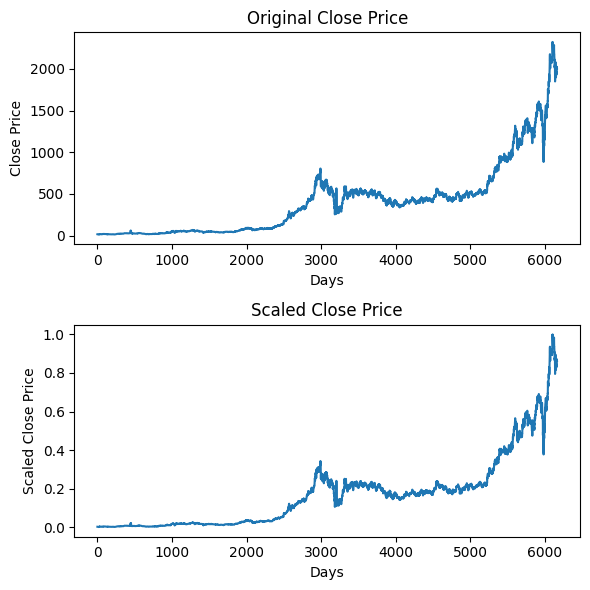

In [92]:
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(dataset)
plt.title('Original Close Price')
plt.xlabel('Days')
plt.ylabel('Close Price')

plt.subplot(2, 1, 2)
plt.plot(scaled_data)
plt.title('Scaled Close Price')
plt.xlabel('Days')
plt.ylabel('Scaled Close Price')

plt.tight_layout()
plt.show()

In [113]:
# Create the training data set

training_data_len = int(np.ceil( len(scaled_data) * .70 ))

print(training_data_len)

train_data = scaled_data[:int(training_data_len), :]

print(train_data.shape)

# Split the data into x_train and y_train data sets

x_train = []
y_train = []

# This loop iterates over the `train_data` to create training samples.
# `i` starts from 60, meaning the first 60 days are used as initial data.

for i in range(60, len(train_data)):

    # x_train: Stores previous 60 days' data as input features.

    x_train.append(train_data[i-60:i, 0])

    # y_train: Stores the closing price 1 day ahead as the target variable.

    y_train.append(train_data[i, 0])

# Example:
# For i = 60:
#   x_train will contain data from days 0 to 59 (60 data points)
#   y_train will contain data from days 60 
# For i = 61:
#   x_train will contain data from days 1 to 60
#   y_train will contain data from days 61
# And so on...


# Convert the x_train and y_train to numpy arrays for easier handling.
x_train, y_train = np.array(x_train), np.array(y_train)

print("x_train shape:", x_train.shape)  
print("y_train shape:", y_train.shape)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
print(y_train.shape)

4315
(4315, 1)
x_train shape: (4255, 60)
y_train shape: (4255,)
(4255, 60, 1)
(4255,)


Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_115 (LSTM)             (None, 60, 80)            26240     
                                                                 
 lstm_116 (LSTM)             (None, 50)                26200     
                                                                 
 dense_60 (Dense)            (None, 1)                 51        
                                                                 
Total params: 52,491
Trainable params: 52,491
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
107/107 [==============================] - 3s 12ms/step - loss: 3.1209e-04 - val_loss: 1.1294e-04 - lr: 0.0010
Epoch 2/100
107/107 [==============================] - 1s 7ms/step - loss: 5.6563e-05 - val_loss: 4.3654e-05 - lr: 0.0010
Epoch 3/100
107/107 [==============================] - 1s 7ms/step -

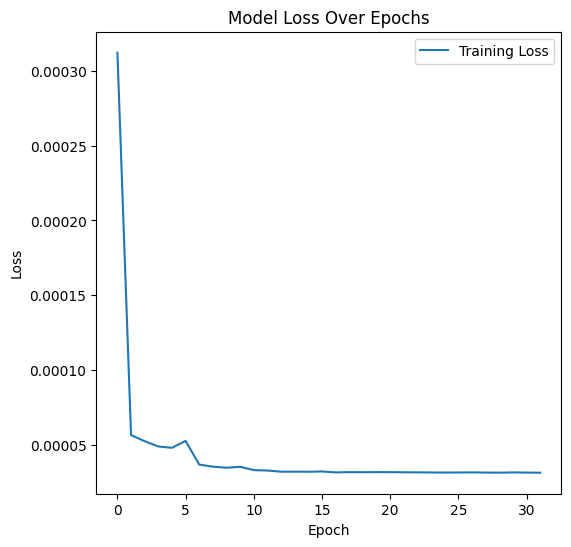

In [ ]:
model = Sequential()  # Create a Sequential model, which is a linear stack of layers
model.add(LSTM(80, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add the first LSTM layer
# - 80 units: The LSTM layer has 80 memory cells
# - return_sequences=True: This LSTM layer will return the entire sequence, allowing for stacking with another LSTM layer
# - input_shape=(x_train.shape[1], 1): Specifies the shape of the input data. Here, it's expected to be (time_steps, features), where features is 1

model.add(LSTM(units=50, return_sequences=False))

# Add the second LSTM layer
# - 50 units: This LSTM layer has 50 memory cells
# - return_sequences=False: This LSTM layer will return only the last output in the output sequence, flattening the output for the Dense layer

model.add(Dense(units=1, activation='relu'))

# Add a Dense layer for the final prediction
# - units=1: The output layer has 1 unit for regression or binary classification
# - activation='relu': Use ReLU activation for non-linearity in the output

model.summary()

# Compile the model
# - optimizer=Adam(learning_rate=0.001): Use Adam optimizer with a learning rate of 0.001 for adaptive learning
# - loss='mean_squared_error': Use Mean Squared Error as the loss function for regression tasks

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Define callbacks for training
# Early Stopping: This callback will stop training when the model's performance on the validation set starts deteriorating

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,                 # Number of epochs to wait before stopping if validation loss does not improve
                               restore_best_weights=True    # Restore model weights from the epoch with the best performance
                               )

# Reduce Learning Rate on Plateau: This callback will decrease the learning rate if the validation loss stops improving

reduce_lr = ReduceLROnPlateau(monitor='val_loss',   # Monitor validation loss
                              factor=0.2,           # Reduce the learning rate by 20% when triggered
                              patience=5,           # Number of epochs to wait before reducing learning rate
                              min_lr=0.00001)        # Minimum learning rate to allow

# Train the model

history = model.fit(x_train, y_train,       # Training data, Training labels
                    batch_size=32,          # Number of samples per gradient update
                    epochs=100,              # Maximum number of epochs to train
                    validation_split=0.2,   # Use 20% of the training data for validation
                    callbacks=[early_stopping, reduce_lr],  # Apply the defined callbacks during training
                    verbose=1)                  # Enable verbose output for progress bar

# Plot the loss over epochs

plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

56/56 [==============================] - 1s 3ms/step
(1789, 1)
(1789, 1)
The root mean squared error is 68.26392258206039.


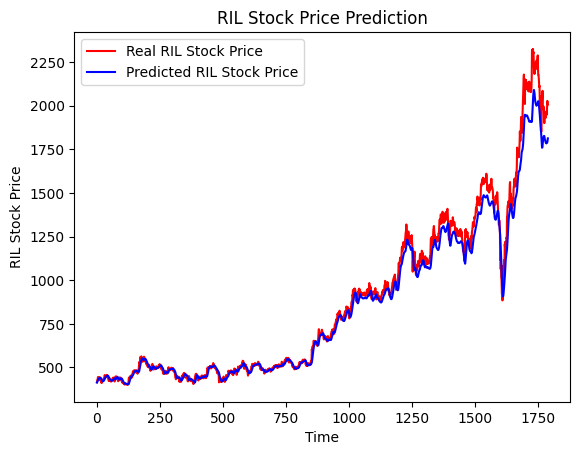

In [ ]:
# Define a function to calculate and print RMSE

def return_rmse(test,predicted):

    # Calculate the Root Mean Squared Error (RMSE) between test and predicted values

    rmse = math.sqrt(mean_squared_error(test, predicted))

    print("The root mean squared error is {}.".format(rmse))

# Create the testing data set
# Slice the scaled data from the end of the training set to the end of the dataset

test_data = scaled_data[training_data_len: , :]

# Extract the original dataset values for testing, starting from 60 time steps after the training data ends
y_test_org = dataset[training_data_len+60:, :] 

# Prepare the input data for the model's predictions
x_test = []

# Loop through the test data, creating sequences of the last 60 time steps as input for each prediction
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the list of sequences into a numpy array for model input
x_test = np.array(x_test)
# Reshape the input data to fit the LSTM model's expected input shape (samples, time steps, features)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Use the trained model to make predictions on the test data
predictions_scaled = model.predict(x_test)

# Inverse transform the predictions to get them back to the original scale
predictions_org = scaler.inverse_transform(predictions_scaled)


print(y_test_org.shape)
print(predictions_scaled.shape)

# Calculate and print the RMSE between the original test values and the model's predictions
return_rmse(y_test_org,predictions_org)

def plot_predictions(test,predicted):
    plt.plot(y_test_org, color='red',label='Real RIL Stock Price')
    plt.plot(predictions_org, color='blue',label='Predicted RIL Stock Price')
    plt.title('RIL Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('RIL Stock Price')
    plt.legend()
    plt.show()
plot_predictions(y_test_org,predictions_org)

In [ ]:


# Load the historical stock data from a CSV file with 'Date' as the index
data_ = pd.read_csv('RELIANCE.NS.csv', index_col='Date', parse_dates=['Date'])

# Print the column names of the dataset
print(data_.keys())

# Remove any rows with missing values to ensure data integrity
data = data_.dropna(inplace=False)  # This returns a new DataFrame

# Select input features for the model (Open, High, and Volume)
input_data = data[['Open', 'High', 'Volume']]

# Print the column names of the input features
print(input_data.keys())

# Extract the 'Close' prices as the output data
output_data = data[['Close']].values

# Initialize separate scalers for input and output features
input_scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the input features to a range between 0 and 1
scaled_data = input_scaler.fit_transform(input_data)

# Normalize the output (Close prices) separately
scaled_output = output_scaler.fit_transform(output_data)

# Define the percentage of data to use for training
training_data_len = int(np.ceil(len(scaled_data) * 0.70))

# Split the data into training and test sets
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len:, :]

# Initialize lists to store sequences for training and testing
x_train, x_test, y_train, y_test, y_test_org = [], [], [], [], []
seq_length = 60  # Number of time steps to look back

# Create sequences for training data
for i in range(len(train_data) - seq_length - 4):
    # Append sequences of 60 time steps for input
    x_train.append(train_data[i:(i + seq_length)])
    # Append the next 5 time steps as output for prediction (since we want to predict 5 future close prices)
    y_train.append(scaled_output[(i + seq_length):(i + seq_length + 5)])

# Create sequences for test data
for i in range(len(test_data) - seq_length - 4):
    # Append sequences of 60 time steps for input
    x_test.append(test_data[i:(i + seq_length)])
    # Append the next 5 time steps as scaled output for prediction
    y_test.append(scaled_output[training_data_len + i + seq_length:
                                training_data_len + i + seq_length + 5])
    # Append the next 5 time steps as original output for comparison
    y_test_org.append(output_data[training_data_len + i + seq_length:
                                  training_data_len + i + seq_length + 5])

# Convert lists to numpy arrays for model input
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
y_test_org = np.array(y_test_org)

# Print shapes for verification
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("y_test_org shape:", y_test_org.shape)


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Volume'], dtype='object')
x_train shape: (4251, 60, 3)
y_train shape: (4251, 5, 1)
x_test shape: (1785, 60, 3)
y_test shape: (1785, 5, 1)
y_test_org shape: (1785, 5, 1)


Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_117 (LSTM)             (None, 60, 80)            26880     
                                                                 
 lstm_118 (LSTM)             (None, 50)                26200     
                                                                 
 dense_61 (Dense)            (None, 5)                 255       
                                                                 
Total params: 53,335
Trainable params: 53,335
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
107/107 [==============================] - 3s 12ms/step - loss: 0.0014 - val_loss: 1.0392e-04 - lr: 0.0010
Epoch 2/100
107/107 [==============================] - 1s 7ms/step - loss: 8.5442e-05 - val_loss: 6.9518e-05 - lr: 0.0010
Epoch 3/100
107/107 [==============================] - 1s 7ms/step - los

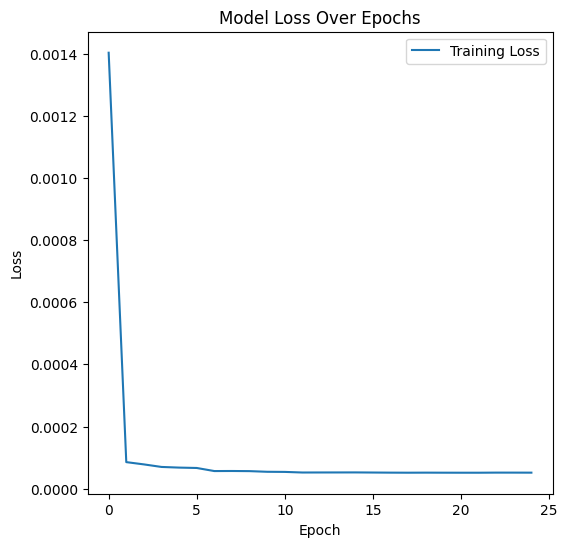

In [ ]:
# Initialize a Sequential model - a linear stack of layers
model = Sequential()

# First LSTM Layer
model.add(LSTM(
    units=80,  # Number of LSTM units/neurons in this layer
    return_sequences=True,  # Return full sequence for next LSTM layer
    input_shape=(x_train.shape[1], 3)  # Input shape: (sequence_length, number_of_features)
    # sequence_length = 60 time steps
    # number_of_features = 3 (Open, High, Volume)
))

# Second LSTM Layer
model.add(LSTM(
    units=50,  # Number of LSTM units/neurons
    return_sequences=False  # Return only the last output (many-to-one architecture)
    # This is needed because we want to connect to a Dense layer next
))

# Output Dense Layer
model.add(Dense(
    units=5,  # Output 5 values (predicting next 5 time steps)
    activation='relu'  # ReLU activation for positive stock price predictions
))

# Display model architecture summary
model.summary()


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model

history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)

plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

In [118]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

predictions_scaled = model.predict(x_test)
print(predictions_scaled.shape)
predictions_org = output_scaler.inverse_transform(predictions_scaled)


print(y_test_org.shape)
print(predictions_scaled.shape)
return_rmse(y_test_org[:,:,0],predictions_org)

56/56 [==============================] - 1s 3ms/step
(1785, 5)
(1785, 5, 1)
(1785, 5)
The root mean squared error is 139.12059042053315.


Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_186 (LSTM)             (None, 200)               163200    
                                                                 
 dense_98 (Dense)            (None, 5)                 1005      
                                                                 
Total params: 164,205
Trainable params: 164,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
107/107 [==============================] - 2s 9ms/step - loss: 0.0011 - val_loss: 6.9198e-05 - lr: 0.0010
Epoch 2/100
107/107 [==============================] - 1s 6ms/step - loss: 6.3706e-05 - val_loss: 5.7752e-05 - lr: 0.0010
Epoch 3/100
107/107 [==============================] - 1s 6ms/step - loss: 5.9424e-05 - val_loss: 5.5709e-05 - lr: 0.0010
Epoch 4/100
107/107 [==============================] - 1s 6ms/step - loss: 6.2069

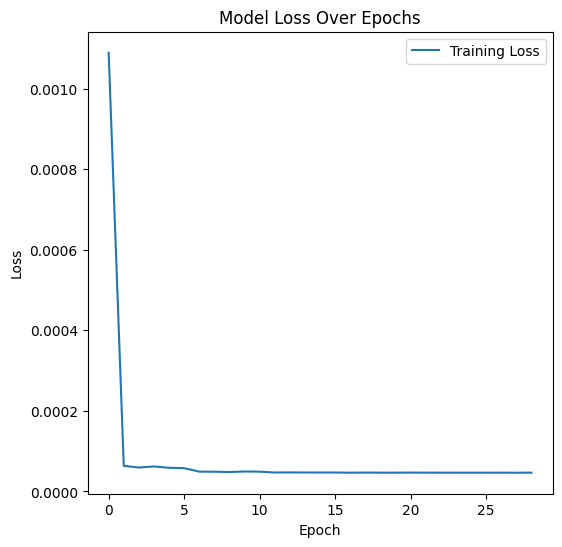

In [176]:
model = Sequential()
model.add(LSTM(200, return_sequences=False, input_shape=(x_train.shape[1], 3)))
#model.add(Dropout(0.3))
# model.add(LSTM(units=20, return_sequences=False))
# model.add(Dropout(0.3))
#model.add(Dense(units=20, activation='tanh'))
model.add(Dense(units=5, activation='relu'))
model.summary()


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model

history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)

plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

In [177]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

predictions_scaled = model.predict(x_test)
print(predictions_scaled.shape)
predictions_org = output_scaler.inverse_transform(predictions_scaled)


print(y_test_org.shape)
print(predictions_scaled.shape)
return_rmse(y_test_org[:,:,0],predictions_org)

56/56 [==============================] - 0s 2ms/step
(1785, 5)
(1785, 5, 1)
(1785, 5)
The root mean squared error is 88.4688188106379.
